# **I. Perkenalan**

```
=======================================================================================================================================
Live Code 4

Nama  : Achmed Alridho Zulkarnaen
Batch : RMT-037

File ipynb ini berisi pembuatan machine learning time series yang dapat memprediksi .
=======================================================================================================================================
```

## Pendahuluan

### Gambaran Dataset
data berisi informasi tentang terjualnya tiket film dalam beberapa cinema milik brand per hari. Terdapat variabel seperti total sales, jumlah tiket terjual, dan informasi tentang tiket lainnya

### Objective
sebagai data scientist di cinema brand membuat model machine learning time series untuk memprediksi seberapa banyak tiket terjual setiap hari untuk minggu ke depannya, dengan itu bisa membantu distribusi staf di setiap studio dan memanajemen FnB stock. Performa model dinilai dengan metric regresi yaitu Mean Absolute Error (MAE)

# **II. Import Libraries**

In [2]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# **III. Data Loading**

In [2]:
df_ori = pd.read_csv('cinemaTicket_Ref.csv')
df = df_ori.copy()
df

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4


In [3]:
# Check info dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc     142399 non-null  float64
 7   ticket_price  142524 non-null  float64
 8   ticket_use    142524 non-null  int64  
 9   capacity      142399 non-null  float64
 10  date          142524 non-null  object 
 11  month         142524 non-null  int64  
 12  quarter       142524 non-null  int64  
 13  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 15.2+ MB


2 kolom yang dibutuhkan untuk timeseries adalah tickets_sold dan date

In [4]:
df_ts = df[['date', 'tickets_sold']]
df_ts.head(10)

,date,tickets_sold
0,2018-05-05,26
1,2018-05-05,42
2,2018-05-05,32
3,2018-05-05,12
4,2018-05-05,15
5,2018-05-05,7
6,2018-05-05,10
7,2018-05-05,5
8,2018-05-05,11
9,2018-05-05,4


Banyak perulangan data, perlu dikelompokkan per hari

In [5]:
df_ts = df_ts.groupby('date', as_index=False)['tickets_sold'].sum()
df_ts

,date,tickets_sold
0,2018-02-21,267
1,2018-02-23,3
2,2018-03-14,20104
3,2018-03-15,41274
4,2018-03-16,51761
...,...,...
229,2018-10-31,47644
230,2018-11-01,80694
231,2018-11-02,86748
232,2018-11-03,45485


In [6]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          234 non-null    object
 1   tickets_sold  234 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [7]:
df_ts.isnull().sum()

date            0
tickets_sold    0
dtype: int64

Text(0, 0.5, 'tickets_sold')

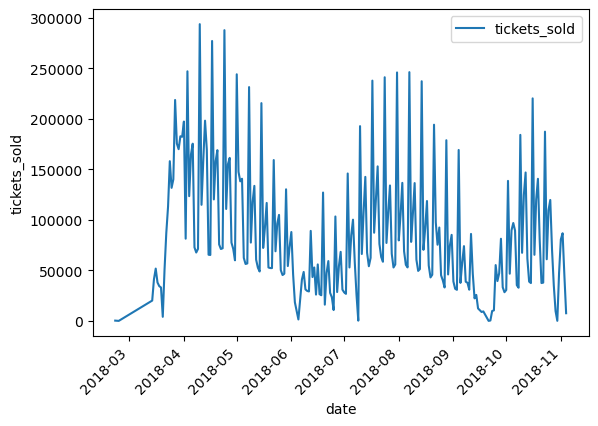

In [8]:
# Plot the data

df_ts.columns = ['date', 'tickets_sold']
df_ts.date = pd.to_datetime(df_ts.date)
df_ts.set_index('date',inplace=True)

df_ts.plot()
plt.xlabel('date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('tickets_sold')

# **IV. Time Series Decomposition**

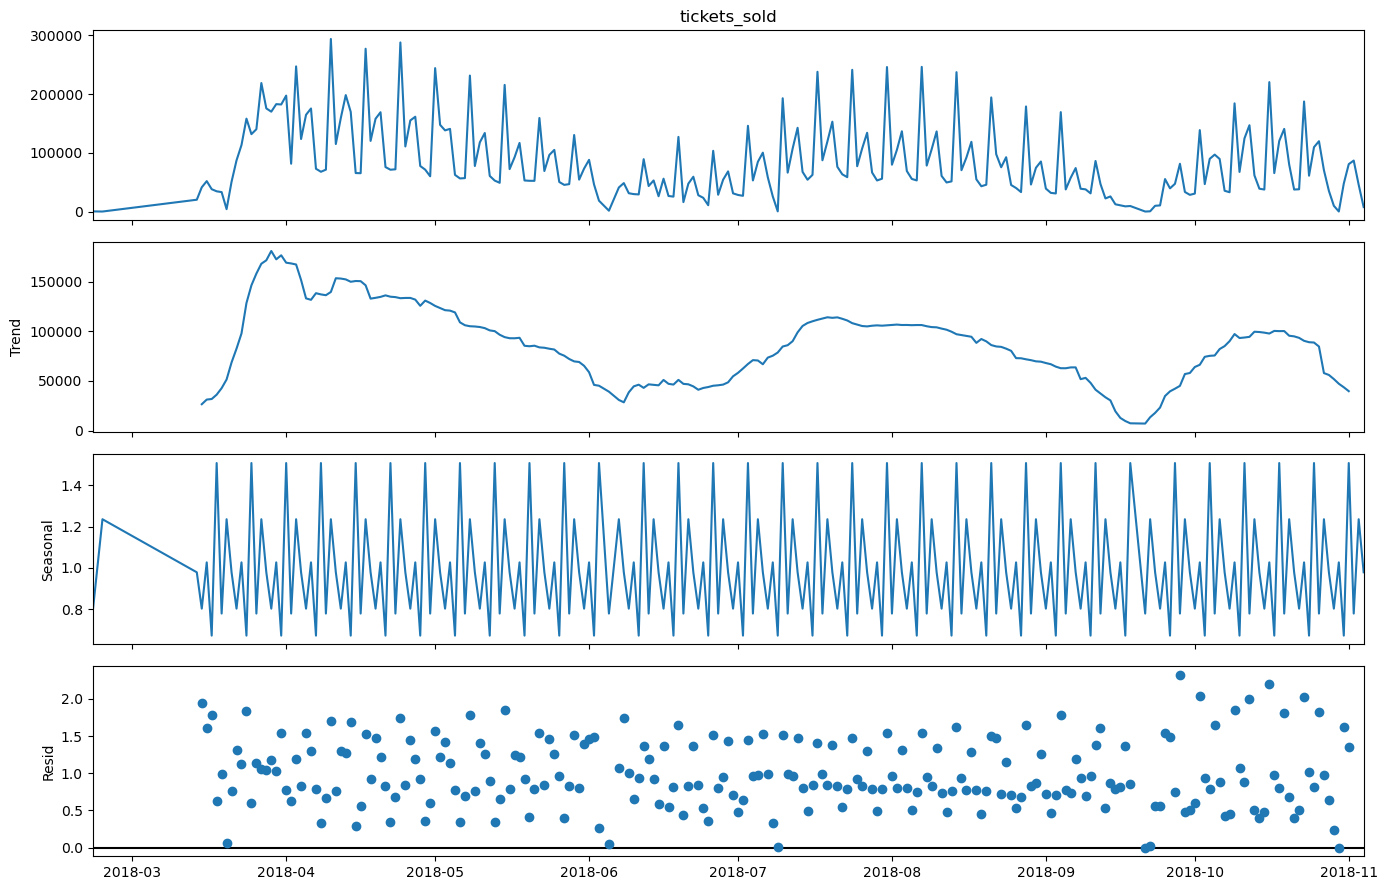

In [9]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_ts['tickets_sold'], model='multiplicative', period=7) #ubah - ubah model, lihat residual
ax=res.plot()
plt.show()

residual mendekati 0, model multiplicative sudah tepat

# **V. Stationary**

## A. Without Differencing

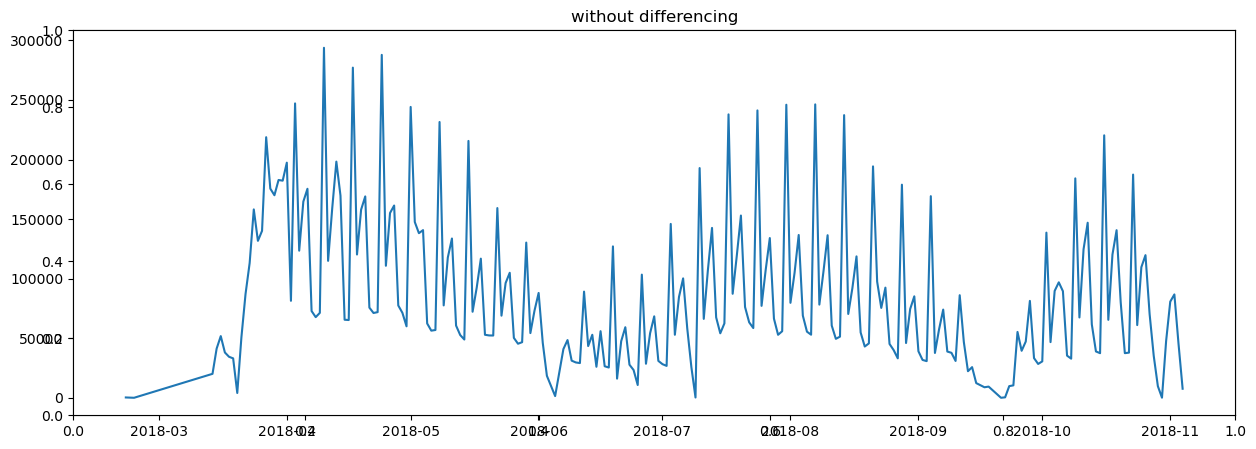

In [10]:
# Plot without differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(df_ts['tickets_sold'])

## B. First-Order Differencing

In [11]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
# Check stationarity of the dataset

check_stationarity(df_ts['tickets_sold'])

ADF Statistic: -2.348107
p-value: 0.156921
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Non-stationary


In [13]:
# Perform first-order differencing

diff1 = df_ts['tickets_sold'].diff()
diff1

date
2018-02-21        NaN
2018-02-23     -264.0
2018-03-14    20101.0
2018-03-15    21170.0
2018-03-16    10487.0
               ...   
2018-10-31    47575.0
2018-11-01    33050.0
2018-11-02     6054.0
2018-11-03   -41263.0
2018-11-04   -37901.0
Name: tickets_sold, Length: 234, dtype: float64

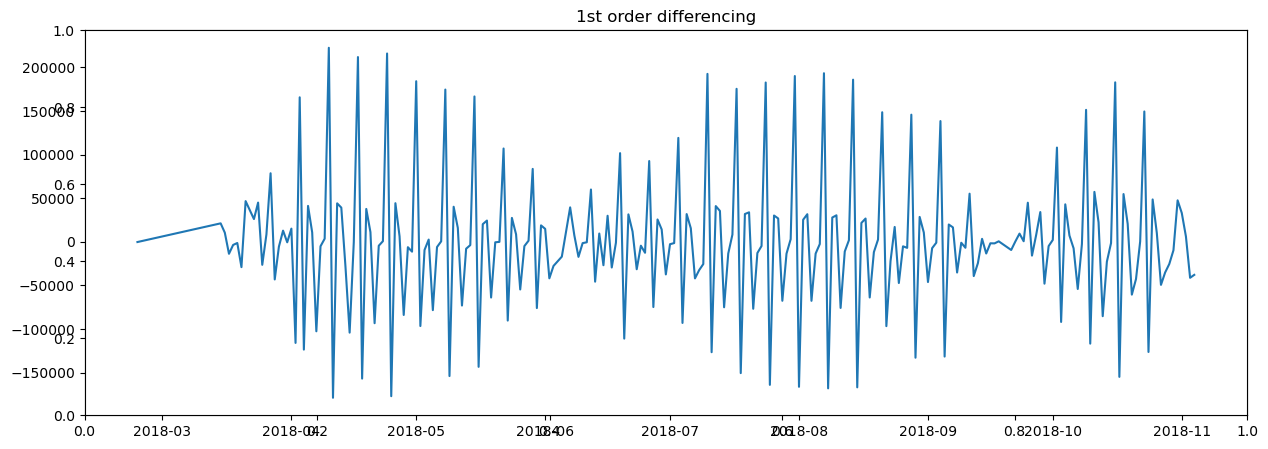

In [14]:
# Plot the result after first-order differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

In [15]:
# Check stationarity after performing first-order differencing

print("1st order differencing")
check_stationarity(diff1.dropna())

1st order differencing
ADF Statistic: -4.971179
p-value: 0.000025
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Stationary


1st order sudah stationary

# **VI. ACF & PACF**

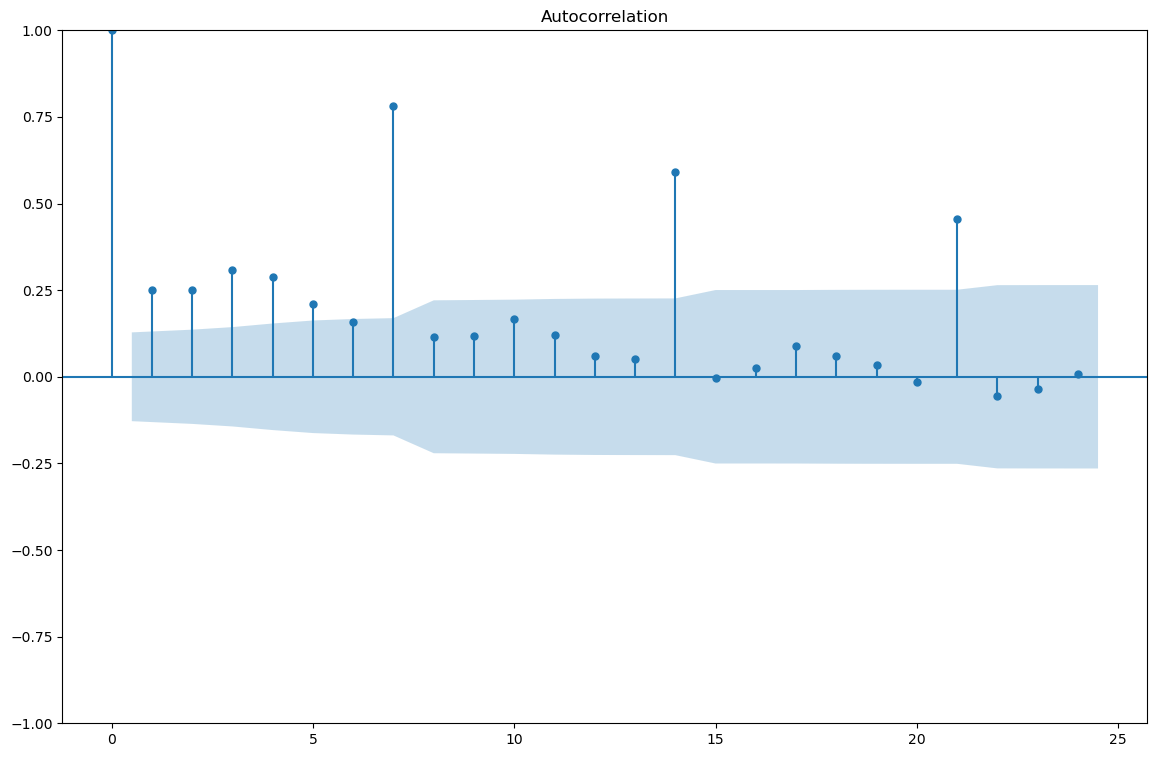

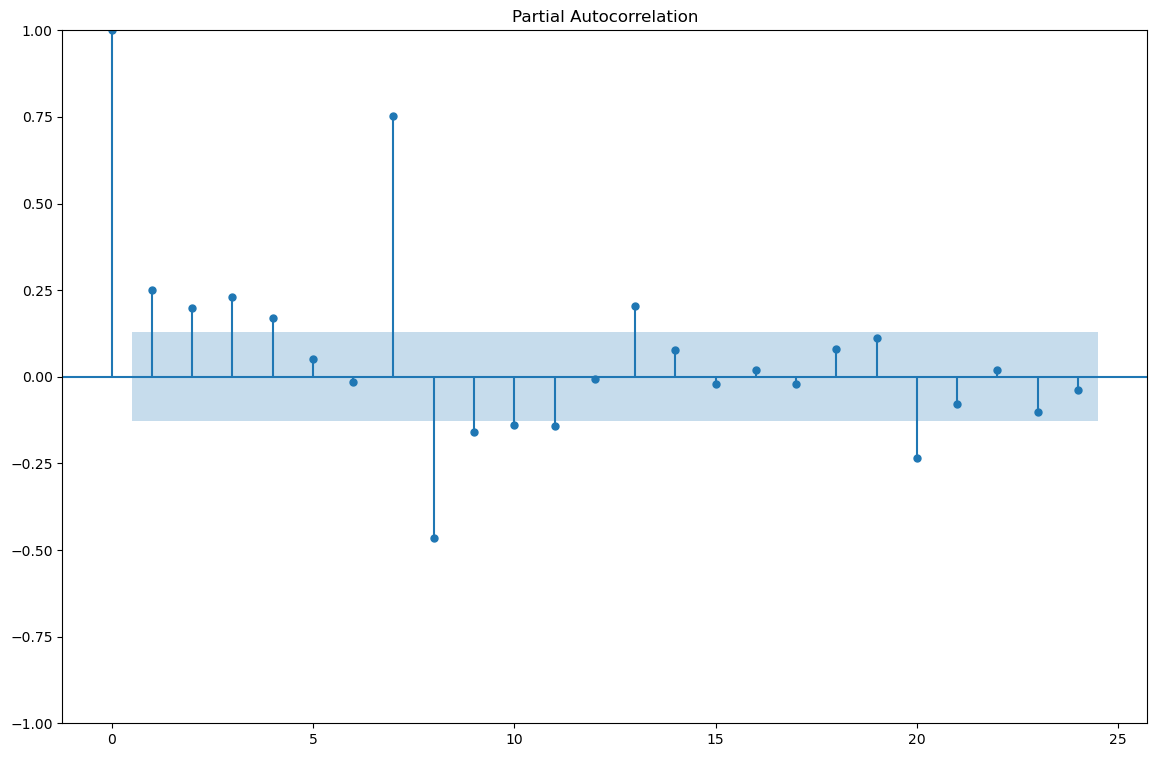

In [16]:
# Plot ACF & PACF from the original dataset

plot_acf(df_ts['tickets_sold'])
plot_pacf(df_ts['tickets_sold'])
plt.show()

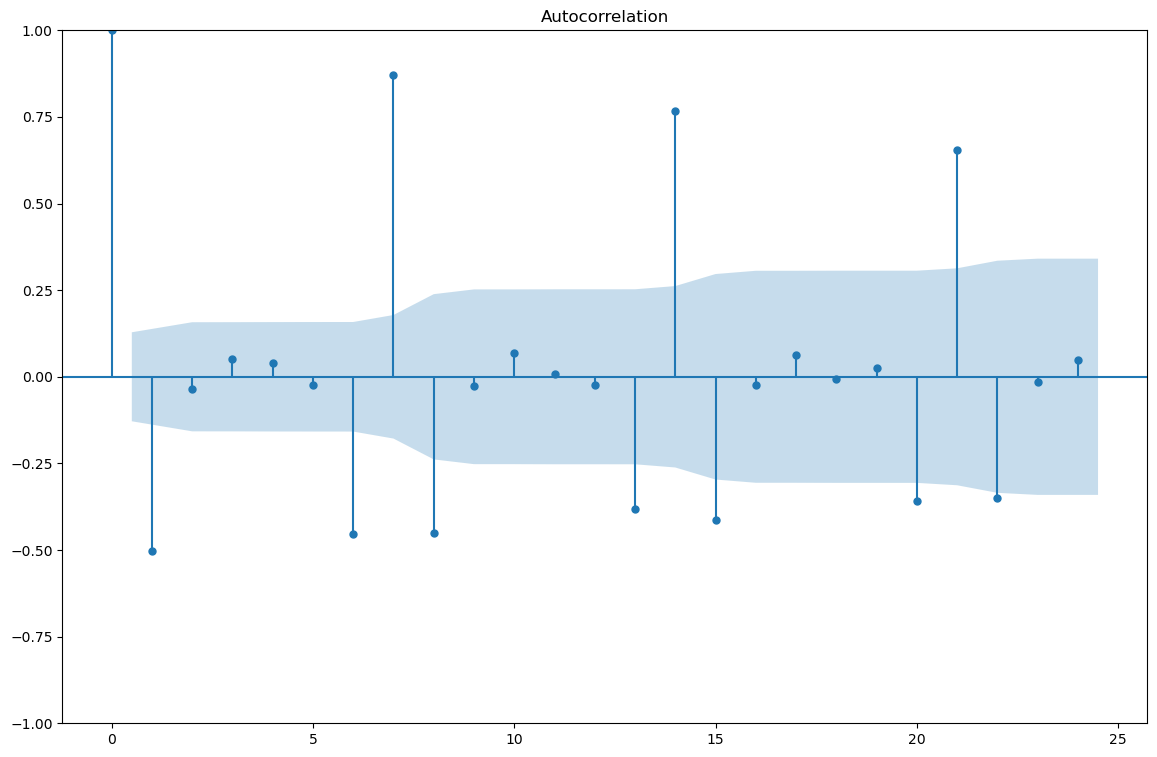

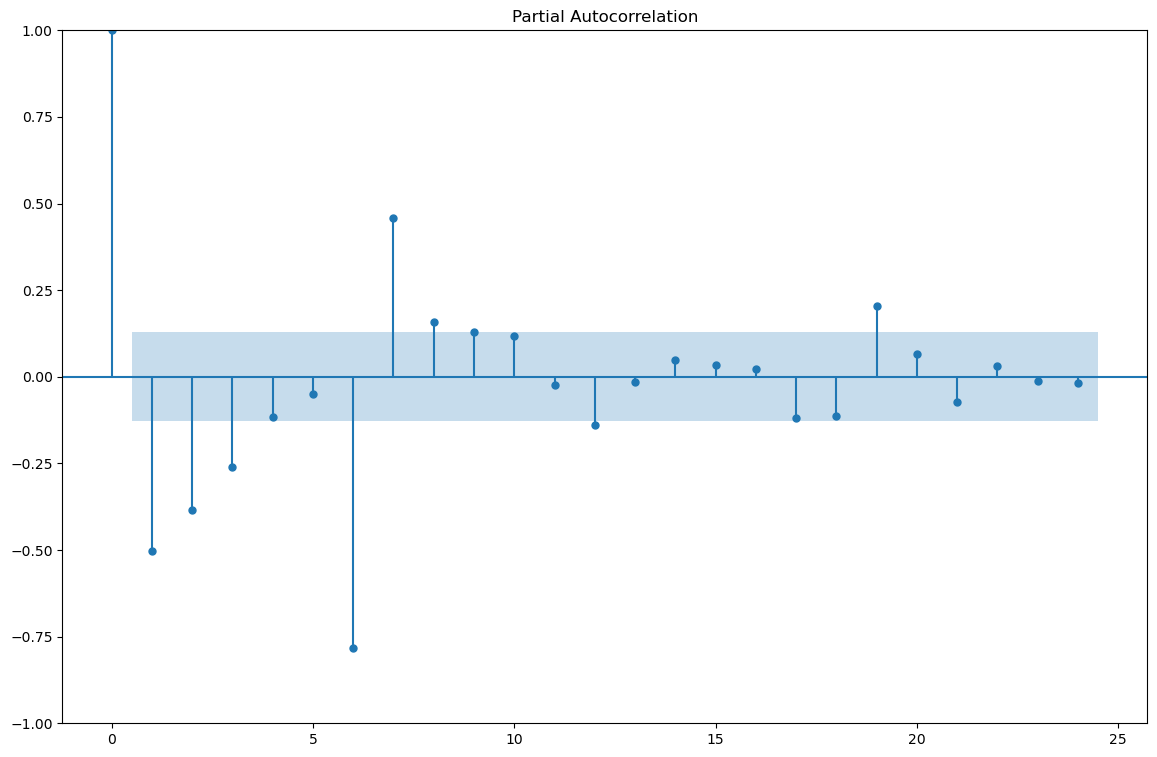

In [17]:
# Plot ACF & PACF after performing first-order differencing

plot_acf(df_ts['tickets_sold'].diff().dropna())
plot_pacf(df_ts['tickets_sold'].diff().dropna())
plt.show()

p (pacf) dan q(acf) ambil 1 garis sebelum cutoff(garis masuk interval)

d = difference

# **VII. ARIMA**

In [18]:
# Train ARIMA with best combinations

model_arima_311 = ARIMA(df_ts['tickets_sold'], order=(3, 1, 1)) #p, d, q
result_model_arima_311 = model_arima_311.fit()

print('The AIC is ', result_model_arima_311.aic)

The AIC is  5766.828133487636


- semakin kecil semakin bagus, nilai entropi dari data time

In [19]:
# Predict next 7 days

len_dataset = df_ts.shape[0]
len_predict = len_dataset + 7

new_pred = result_model_arima_311.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)

start_date = df_ts.index[-1] + pd.Timedelta(days=1)
new_pred.index = pd.date_range(start=start_date, periods=len(new_pred), freq='D')
new_pred.index.name = 'date'

new_pred.columns=['tickets_sold']
all_dataset_with_pred = pd.concat([df_ts, new_pred], axis=0)

In [20]:
# Original dataset

df_ts.tail(5)

,tickets_sold
date,
2018-10-31,47644
2018-11-01,80694
2018-11-02,86748
2018-11-03,45485
2018-11-04,7584


In [21]:
# Prediction of next 12 months

new_pred

,tickets_sold
date,
2018-11-05,55763.458830
2018-11-06,54557.446698
2018-11-07,49208.357579
2018-11-08,48128.164086
2018-11-09,49199.938057
2018-11-10,49416.536823
2018-11-11,49263.593421
2018-11-12,49208.734094


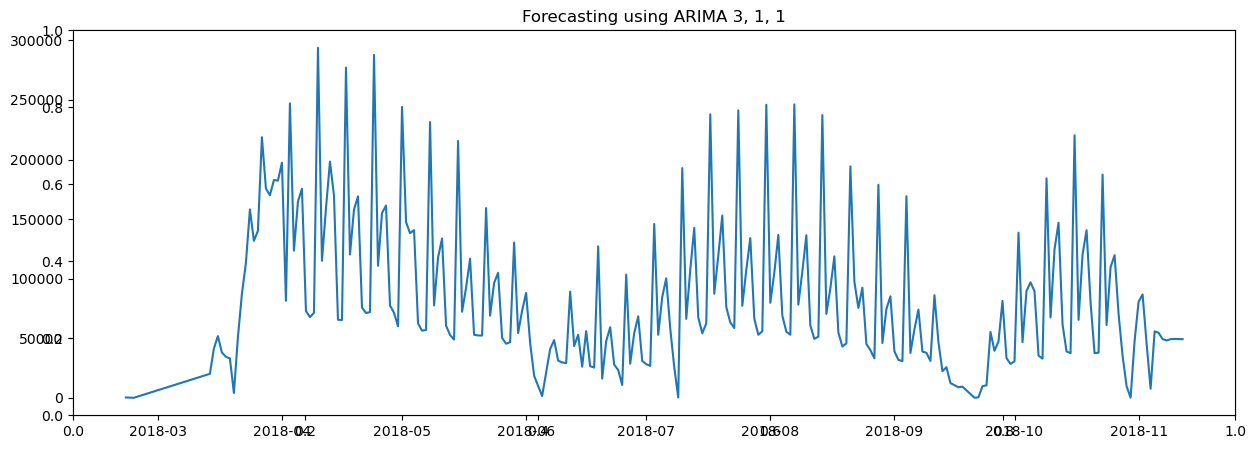

In [22]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using ARIMA 3, 1, 1')
ax1.plot(all_dataset_with_pred)

# **VIII. Modeling**

## A. ARIMA

In [23]:
len(df_ts)

234

In [24]:
# Splitting dataset

train = df_ts[:170]
test = df_ts[170:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (170, 1)
Test size :  (64, 1)


In [25]:
# urutan tanggal
train = train.asfreq('D')
test = test.asfreq('D')

# isi yang tidak ada
train['tickets_sold'].fillna(0, inplace=True)
test['tickets_sold'].fillna(0, inplace=True)

In [26]:
# Stationarity check

check_stationarity(train['tickets_sold'])

ADF Statistic: -2.808108
p-value: 0.057125
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Non-stationary


In [27]:
# First-order differencing

check_stationarity(train['tickets_sold'].diff().dropna())

ADF Statistic: -3.584478
p-value: 0.006065
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Stationary


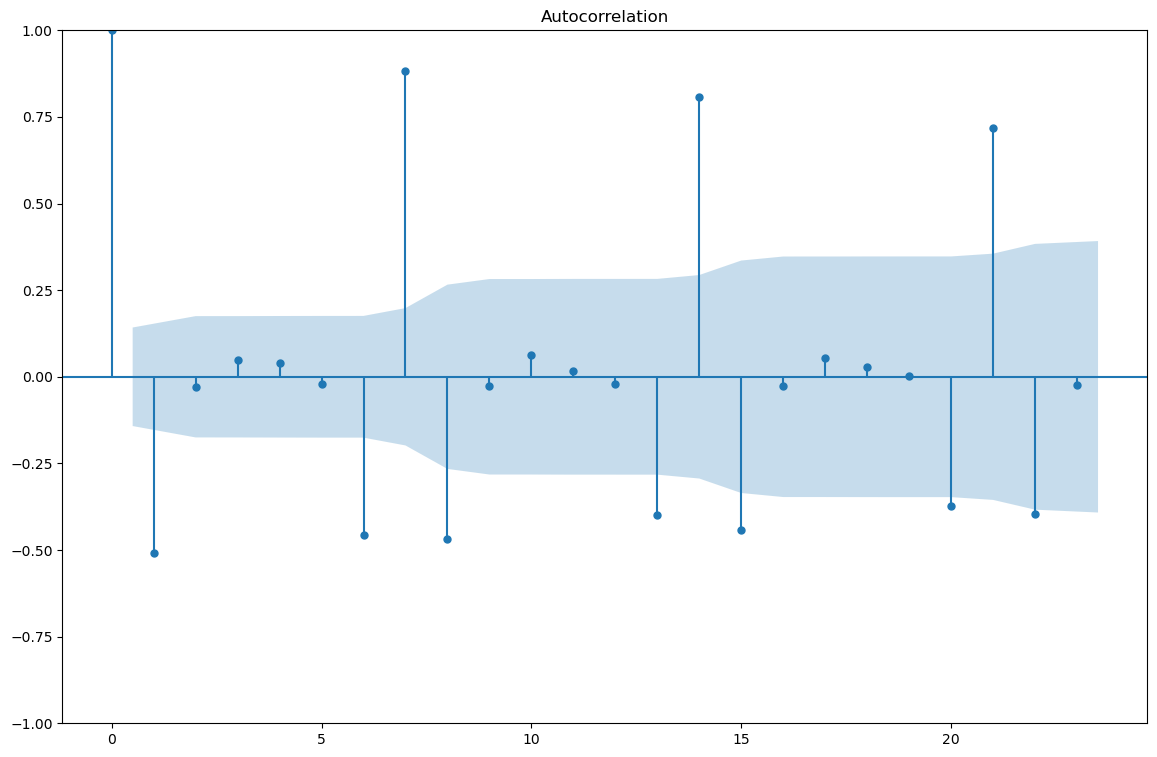

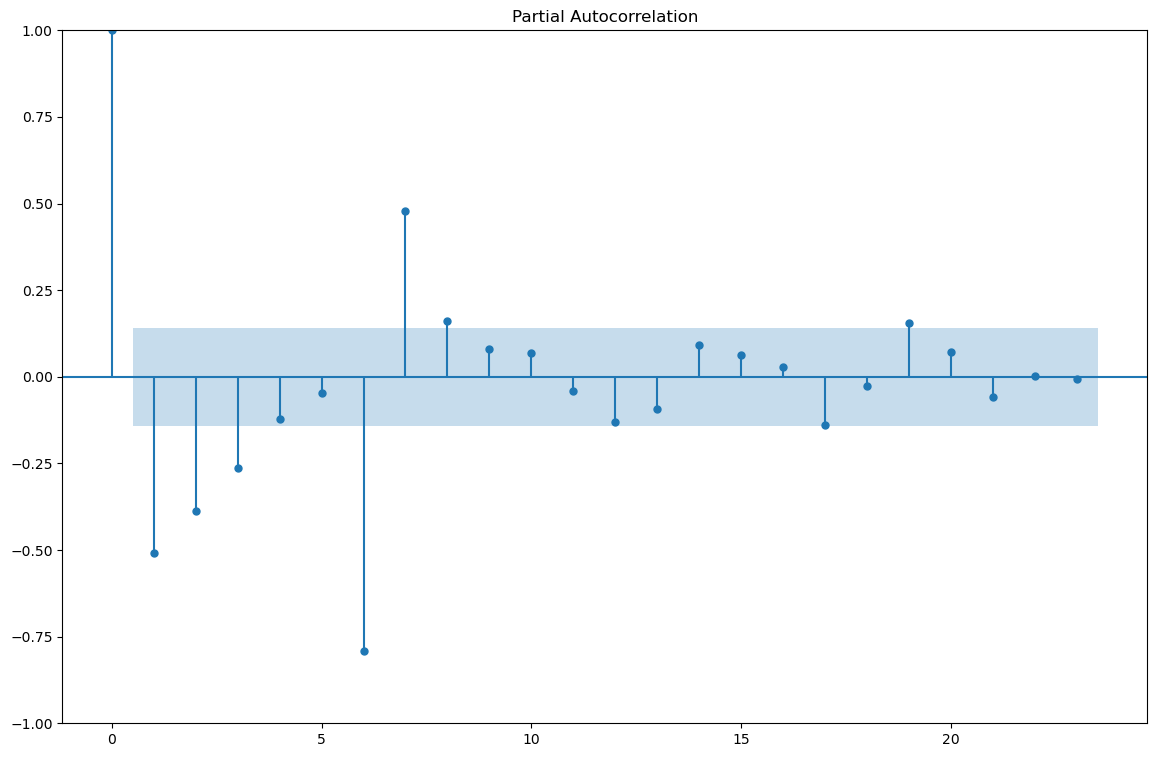

In [28]:
# Check plot ACF & PACF

plot_acf(train['tickets_sold'].diff().dropna())
plot_pacf(train['tickets_sold'].diff().dropna())
plt.show()

In [29]:
# Train with p=3, d=1, q=1

arima = ARIMA(train, order=(3, 1, 1))
mod_train = arima.fit()
mod_train.aic

4704.587132009903

In [30]:
print(test.index.min())
print(test.index.max())

2018-08-31 00:00:00
2018-11-04 00:00:00


In [31]:
## Predict test-set
ari_pred_test = mod_train.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
ari_pred_test = pd.DataFrame(ari_pred_test)
ari_pred_test.columns = ['tickets_sold_predict']

## Concate with actual test-set
act_vs_pred_ari=pd.concat([test, ari_pred_test], axis=1)
act_vs_pred_ari

,tickets_sold,tickets_sold_predict
2018-08-31,85167.0,80685.769620
2018-09-01,39044.0,81351.038004
2018-09-02,31772.0,78995.945842
2018-09-03,30761.0,79065.827627
2018-09-04,169217.0,79371.790108
...,...,...
2018-10-31,47644.0,79354.567910
2018-11-01,80694.0,79354.567910
2018-11-02,86748.0,79354.567910
2018-11-03,45485.0,79354.567910


In [32]:
print('MAE test  : ', mean_absolute_error(test, ari_pred_test))
print('RMSE test : ', np.sqrt(mean_squared_error(test, ari_pred_test)))
print('R2 Test: ', r2_score(test, ari_pred_test))

MAE test  :  45360.900927943534
RMSE test :  53434.377678899604
R2 Test:  -0.15588150602460527


## B. SARIMA

In [33]:
# Splitting dataset

train = df_ts[:170]
test = df_ts[170:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (170, 1)
Test size :  (64, 1)


In [34]:
train

,tickets_sold
date,
2018-02-21,267
2018-02-23,3
2018-03-14,20104
2018-03-15,41274
2018-03-16,51761
...,...
2018-08-26,40022
2018-08-27,33097
2018-08-28,178864


In [35]:
test

,tickets_sold
date,
2018-08-31,85167
2018-09-01,39044
2018-09-02,31772
2018-09-03,30761
2018-09-04,169217
...,...
2018-10-31,47644
2018-11-01,80694
2018-11-02,86748


Tanggal tidak sepenuhnya berurutan, ada beberapa tanggal yang tidak ada

In [36]:
# Pastikan tanggal berurutan
train = train.asfreq('D')
test = test.asfreq('D')

# Isi tanggal yang hilang
train['tickets_sold'].fillna(0, inplace=True)
test['tickets_sold'].fillna(0, inplace=True)

In [37]:
# Display train-set

train

,tickets_sold
date,
2018-02-21,267.0
2018-02-22,0.0
2018-02-23,3.0
2018-02-24,0.0
2018-02-25,0.0
...,...
2018-08-26,40022.0
2018-08-27,33097.0
2018-08-28,178864.0


In [38]:
# Display train-set

test

,tickets_sold
date,
2018-08-31,85167.0
2018-09-01,39044.0
2018-09-02,31772.0
2018-09-03,30761.0
2018-09-04,169217.0
...,...
2018-10-31,47644.0
2018-11-01,80694.0
2018-11-02,86748.0


In [39]:
# Train using SARIMAX


sar=SARIMAX(train, order=(3, 1, 1),seasonal_order=(3, 1, 1, 7)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      tickets_sold   No. Observations:                  191
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -2144.520
Date:                           Sun, 17 Nov 2024   AIC                           4307.040
Time:                                   15:32:42   BIC                           4335.926
Sample:                               02-21-2018   HQIC                          4318.749
                                    - 08-30-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4393      0.065      6.769      0.000       0.312       0.566
ar.L2          0.1657      0.080      2.081      0.037       0.010       0.322
ar.L3          0.1703      0.078      2.175      0.030       0.017       0.324
ma.L1         -0.9959      0.067    -14.921      0.000      -1.127      -0.865
ar.S.L7       -1.0704      0.507     -2.112      0.035      -2.064      -0.077
ar.S.L14      -0.1957      0.166     -1.182      0.237      -0.520       0.129
ar.S.L21       0.0374      0.084      0.443      0.658      -0.128       0.203
ma.S.L7        0.8245      0.500      1.648      0.099      -0.156       1.805
sigma2      1.008e+09   4.83e-10   2.09e+18      0.000    1.01e+09    1.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               115.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+34. Standard errors may be unstable.
"""

In [40]:
sar.aic

4307.040371891169

In [41]:
## Predict test-set
sar_pred_test = sar.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['tickets_sold_predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,tickets_sold,tickets_sold_predict
2018-08-31,85167.0,84595.076982
2018-09-01,39044.0,32888.006726
2018-09-02,31772.0,31602.972403
2018-09-03,30761.0,29520.303224
2018-09-04,169217.0,175357.589662
...,...,...
2018-10-31,47644.0,60807.763512
2018-11-01,80694.0,81133.493727
2018-11-02,86748.0,93517.500488
2018-11-03,45485.0,44038.836670


In [42]:
# Check the MAE & RMSE

print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('RMSE test : ', np.sqrt(mean_squared_error(test, sar_pred_test)))
print('R2 Test: ', r2_score(test, sar_pred_test))

MAE test  :  26876.769111900096
RMSE test :  44841.5631644308
R2 Test:  0.18598334504287362


inference timeseries tidak perlu beda file

# **IX. Inference**

prediksi 7 hari setelah index akhir data test

In [43]:
sar_pred_inf = sar.predict(start='2018-11-05', end='2018-11-11', dynamic=True)
sar_pred_inf = pd.DataFrame(sar_pred_inf)
sar_pred_inf.columns = ['tickets_sold_predict']
sar_pred_inf

,tickets_sold_predict
2018-11-05,39730.864768
2018-11-06,186134.149936
2018-11-07,63214.610558
2018-11-08,82642.876966
2018-11-09,95023.743724
2018-11-10,45655.864284
2018-11-11,44518.413429


# **X. Kesimpulan**